GBM R2: 0.465
GBM MSE: 0.395
SVR R2: 0.374
SVR MSE: 0.462


/Users/maksim/PycharmProjects/pythonProject4/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maksim/PycharmProjects/pythonProject4/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maksim/PycharmProjects/pythonProject4/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maksim/PycharmProjects/pythonProject4/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

MLP R2: 0.360
MLP MSE: 0.473


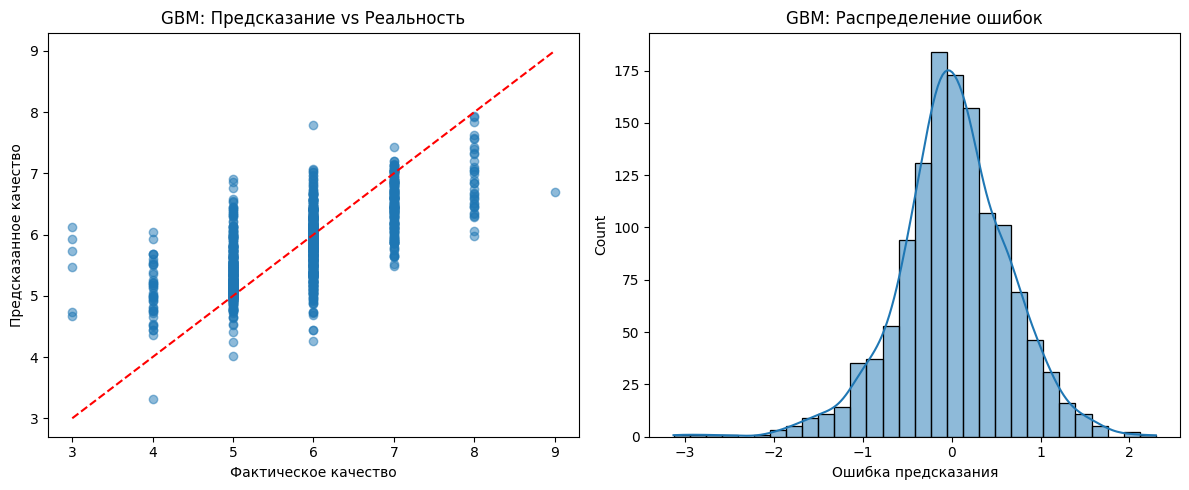

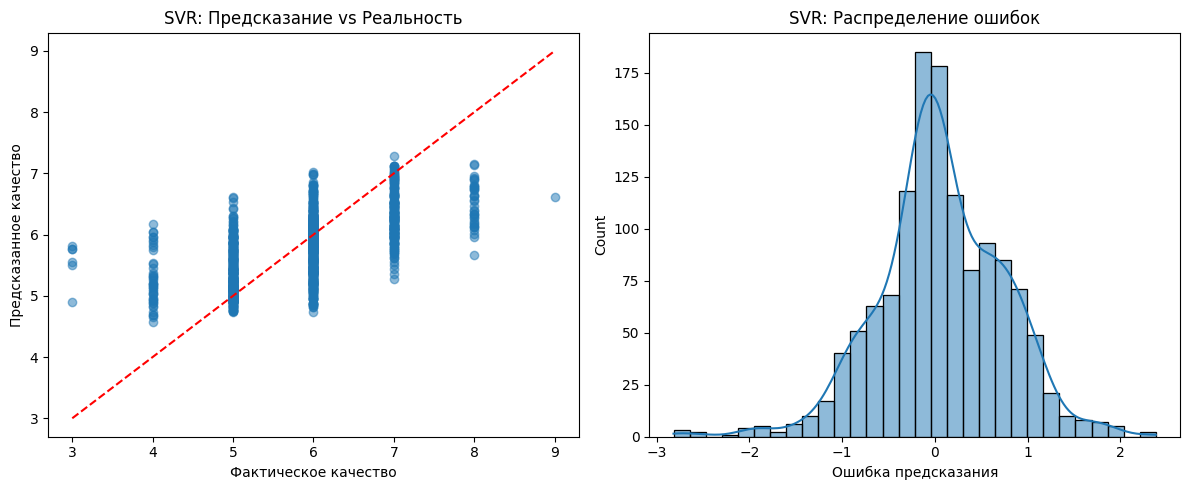

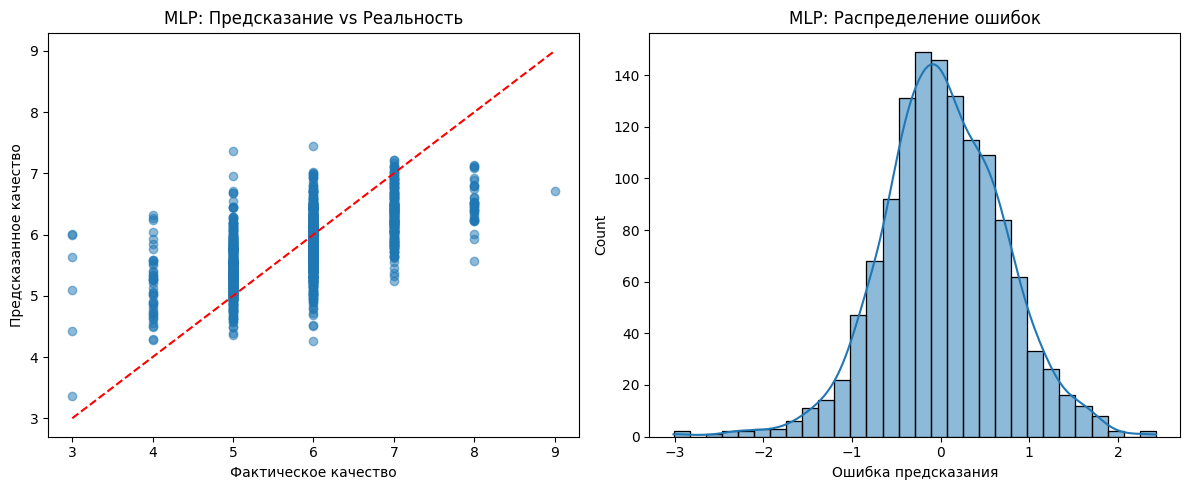

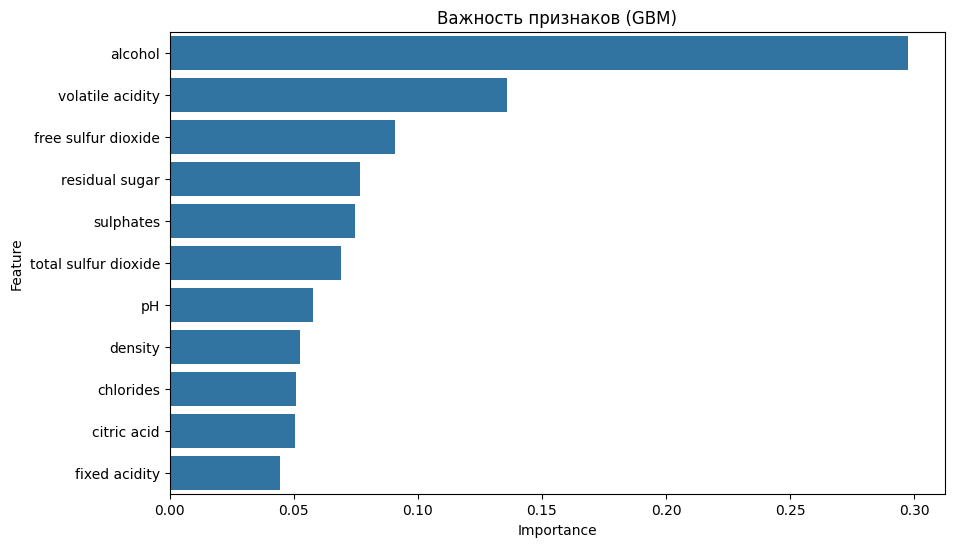

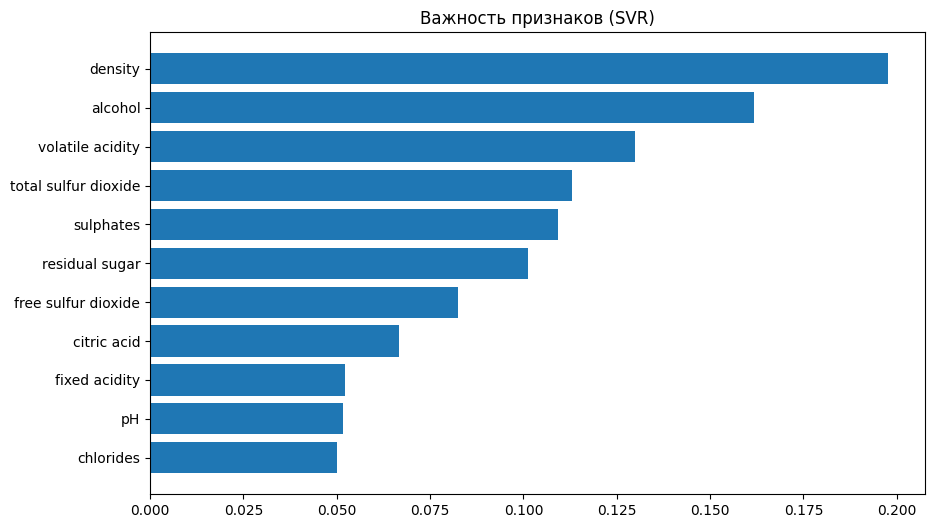

  Model        R2       MSE
0   GBM  0.465438  0.394799
1   SVR  0.373956  0.462363
2   MLP  0.360015  0.472659


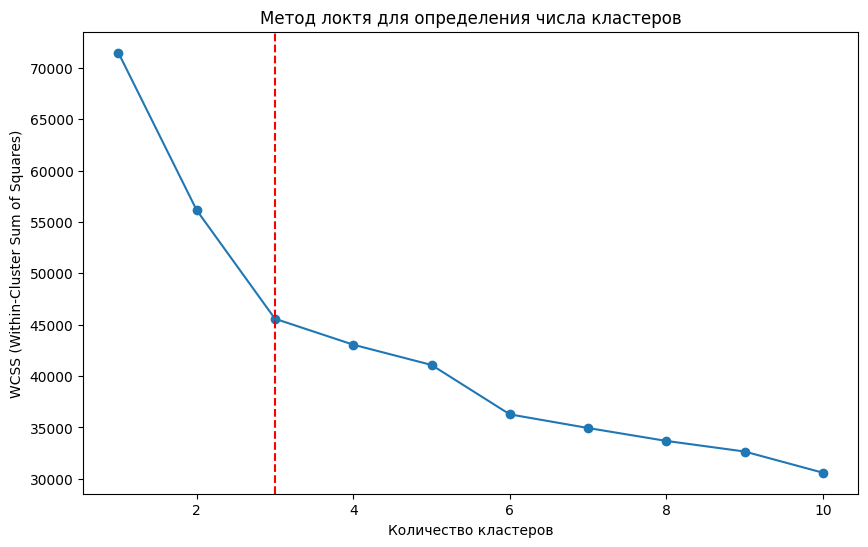

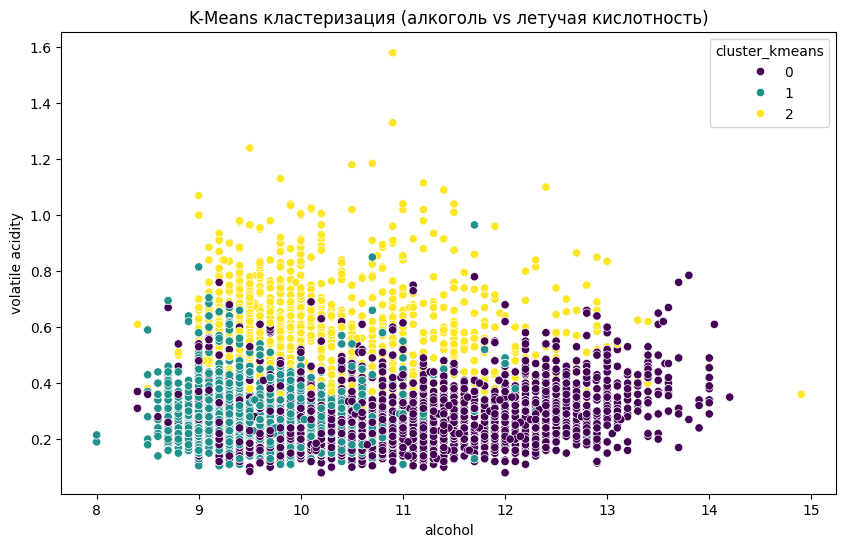

                fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster_kmeans                                                                 
0                    6.762396          0.273320     0.317843        3.367464   
1                    6.976635          0.281680     0.359003       11.152848   
2                    8.355590          0.534124     0.272048        2.566709   

                chlorides  free sulfur dioxide  total sulfur dioxide  \
cluster_kmeans                                                         
0                0.040511            28.909937            117.709538   
1                0.052926            45.549314            169.816192   
2                0.089074            15.685616             47.633794   

                 density        pH  sulphates    alcohol   quality      type  
cluster_kmeans                                                                
0               0.992142  3.212134   0.489109  11.170487  6.061815  0.981057  
1

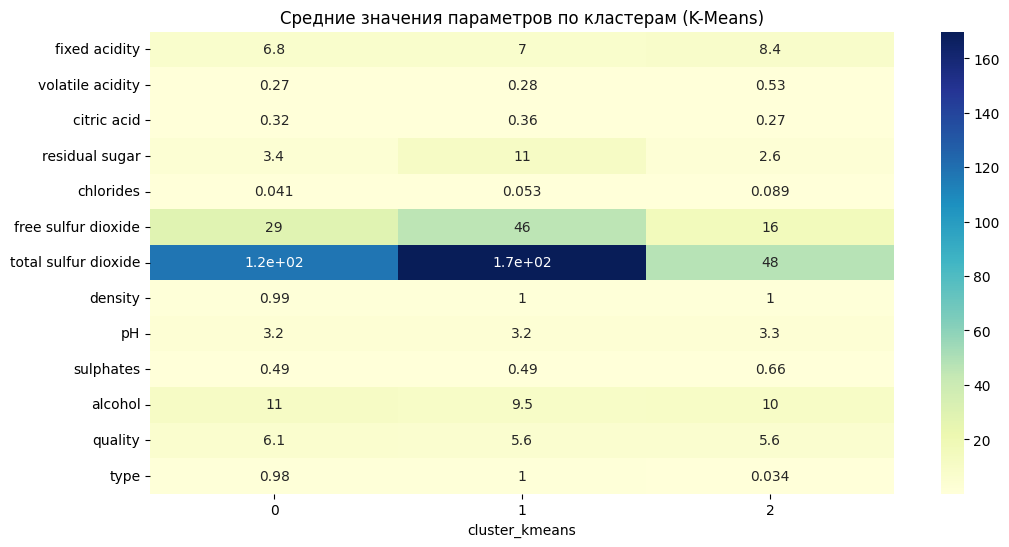

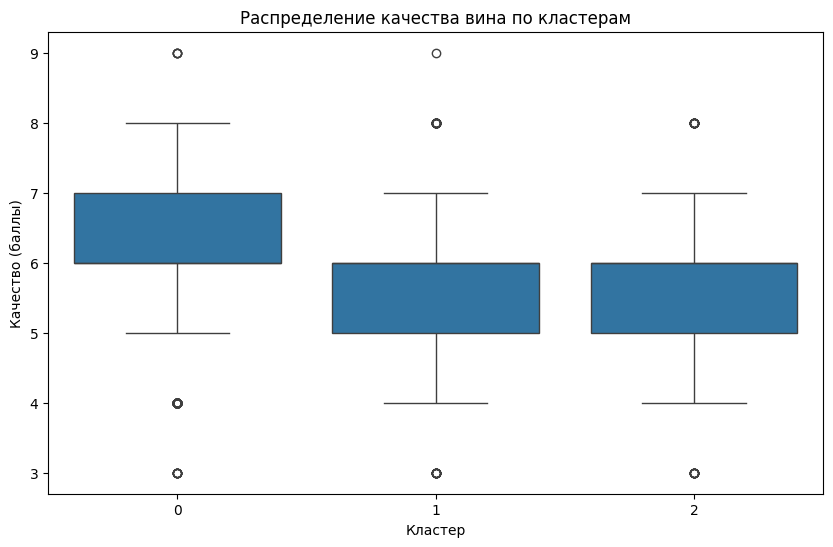

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile


zip_path = 'archive10.zip'
extract_path = 'wine_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

red = pd.read_csv(os.path.join(extract_path, 'winequality-red.csv'), sep=';')
white = pd.read_csv(os.path.join(extract_path, 'winequality-white.csv'), sep=';')
red['type'] = 0  # 0 для красного вина
white['type'] = 1 # 1 для белого вина
wine = pd.concat([red, white])

X = wine.drop(['quality', 'type'], axis=1)
y = wine['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

gbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5]
}

gbm_grid = GridSearchCV(gbm, gbm_params, cv=5, scoring='r2', n_jobs=-1)
gbm_grid.fit(X_train, y_train)
best_gbm = gbm_grid.best_estimator_


y_pred_gbm = best_gbm.predict(X_test)
print(f"GBM R2: {r2_score(y_test, y_pred_gbm):.3f}")
print(f"GBM MSE: {mean_squared_error(y_test, y_pred_gbm):.3f}")
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto']
}

svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='r2', n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train)
best_svr = svr_grid.best_estimator_


y_pred_svr = best_svr.predict(X_test_scaled)
print(f"SVR R2: {r2_score(y_test, y_pred_svr):.3f}")
print(f"SVR MSE: {mean_squared_error(y_test, y_pred_svr):.3f}")
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,50), early_stopping=True, random_state=42)
mlp.fit(X_train_scaled, y_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,50), (100,100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='r2', n_jobs=-1)
mlp_grid.fit(X_train_scaled, y_train)
best_mlp = mlp_grid.best_estimator_


y_pred_mlp = best_mlp.predict(X_test_scaled)
print(f"MLP R2: {r2_score(y_test, y_pred_mlp):.3f}")
print(f"MLP MSE: {mean_squared_error(y_test, y_pred_mlp):.3f}")
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Фактическое качество')
    plt.ylabel('Предсказанное качество')
    plt.title(f'{model_name}: Предсказание vs Реальность')
    
    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, bins=30, kde=True)
    plt.title(f'{model_name}: Распределение ошибок')
    plt.xlabel('Ошибка предсказания')
    
    plt.tight_layout()
    plt.show()

plot_results(y_test, y_pred_gbm, "GBM")
plot_results(y_test, y_pred_svr, "SVR")
plot_results(y_test, y_pred_mlp, "MLP")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_gbm.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков (GBM)')
plt.show()

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_svr, X_test_scaled, y_test, n_repeats=10)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Важность признаков (SVR)")
plt.show()
results = []
models = {
    'GBM': best_gbm,
    'SVR': best_svr,
    'MLP': best_mlp
}

for name, model in models.items():
    if name == 'GBM':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)
    
    results.append({
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(results_df)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Удалим целевую переменную и масштабируем данные
X = wine.drop(['quality', 'type'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Метод локтя для выбора количества кластеров
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Метод локтя для определения числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.axvline(x=3, color='r', linestyle='--')  # Оптимальное число кластеров
plt.show()

# KMeans с 3 кластерами
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Добавляем кластеры в исходные данные
wine['cluster_kmeans'] = clusters_kmeans

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x='alcohol', y='volatile acidity', hue='cluster_kmeans', 
                data=wine, palette='viridis')
plt.title('K-Means кластеризация (алкоголь vs летучая кислотность)')
plt.show()

# Сравнение средних значений по кластерам (K-Means)
cluster_stats = wine.groupby('cluster_kmeans').mean()
print(cluster_stats)

# Визуализация характеристик кластеров
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_stats.T, cmap='YlGnBu', annot=True)
plt.title('Средние значения параметров по кластерам (K-Means)')
plt.show()

# Распределение качества по кластерам
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_kmeans', y='quality', data=wine)
plt.title('Распределение качества вина по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Качество (баллы)')
plt.show()



In [7]:
from sklearn.decomposition import PCA
X = wine.drop(['quality', 'type'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# В DataFrame для удобства
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

pca_df['cluster'] = clusters_pca

import plotly.express as px

fig = px.scatter(pca_df, x='PC1', y='PC2', color='cluster',
                 title='Кластеризация KMeans на PCA-пространстве (2D)',
                 color_continuous_scale='Viridis')
fig.show()

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

pca_3d_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

kmeans_pca_3d = KMeans(n_clusters=3, random_state=42)
clusters_pca_3d = kmeans_pca_3d.fit_predict(X_pca_3d)

pca_3d_df['cluster'] = clusters_pca_3d

fig_3d = px.scatter_3d(pca_3d_df, x='PC1', y='PC2', z='PC3', color='cluster',
                       title='Кластеризация KMeans на PCA-пространстве (3D)',
                       color_continuous_scale='Viridis')
fig_3d.show()



Explained variance ratio: [0.32406533 0.20407926]


In [ ]:
from sklearn.ensemble import IsolationForest

red_wine = wine[wine['type'] == 0].copy()
white_wine = wine[wine['type'] == 1].copy()

def find_anomalies(data, contamination=0.05):
    clf = IsolationForest(contamination=contamination, random_state=42)
    anomalies = clf.fit_predict(data.drop(['quality', 'type', 'cluster_kmeans'], axis=1))
    return data[anomalies == -1]

# Находим аномалии
red_anomalies = find_anomalies(red_wine)
white_anomalies = find_anomalies(white_wine)

print(f"Найдено {len(red_anomalies)} аномальных красных вин")
print(f"Найдено {len(white_anomalies)} аномальных белых вин")

Найдено 80 аномальных красных вин
Найдено 245 аномальных белых вин


In [ ]:
def analyze_anomalies(anomalies, class_name):
    class_mean = wine[wine['type'] == (0 if class_name == 'red' else 1)].mean()
    anomaly_mean = anomalies.mean()
    
    comparison = pd.DataFrame({
        'Class Mean': class_mean,
        'Anomaly Mean': anomaly_mean,
        'Difference': anomaly_mean - class_mean
    })
    
    print(f"\nСравнение аномальных {class_name} вин с классом:")
    display(comparison.sort_values('Difference', key=abs, ascending=False))
    
    return comparison

red_comparison = analyze_anomalies(red_anomalies, 'red')
white_comparison = analyze_anomalies(white_anomalies, 'white')


Сравнение аномальных red вин с классом:


,Class Mean,Anomaly Mean,Difference
total sulfur dioxide,46.467792,88.400000,41.932208
free sulfur dioxide,15.874922,26.106250,10.231328
residual sugar,2.538806,4.506250,1.967444
cluster_kmeans,1.926204,1.525000,-0.401204
sulphates,0.658149,0.906000,0.247851
alcohol,10.422983,10.632083,0.209100
citric acid,0.270976,0.387750,0.116774
pH,3.311113,3.204375,-0.106738
chlorides,0.087467,0.171937,0.084471
fixed acidity,8.319637,8.401250,0.081613



Сравнение аномальных white вин с классом:


,Class Mean,Anomaly Mean,Difference
total sulfur dioxide,138.360657,158.004082,19.643424
free sulfur dioxide,35.308085,40.973469,5.665384
residual sugar,6.391415,9.095306,2.703891
quality,5.877909,5.424490,-0.453420
cluster_kmeans,0.408330,0.800000,0.391670
alcohol,10.514267,10.213197,-0.301070
fixed acidity,6.854788,7.039592,0.184804
volatile acidity,0.278241,0.390041,0.111800
citric acid,0.334192,0.417755,0.083564
pH,3.188267,3.150204,-0.038063
